##### 本章内容
- 神经网络
- 创建验证码和字母数据集
- 用scikit-iamge库处理图像数据
- 神经网络库PyBrain
- 从图像中抽取基本特征
- 使用神经网络进行更大规模的分类任务
- 用后处理提升效果

### 1. 准备数据集
- 绘制验证码

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf
from skimage.measure import label, regionprops
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder

In [8]:
# !pip3 install  scikit-image  -i https://pypi.tuna.tsinghua.edu.cn/simple

In [18]:
def create_captcha(text, shear=0, size=(100, 24)):
    """
    :chear: 错位
    """
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"./data/Coval-Book.otf", 22)
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

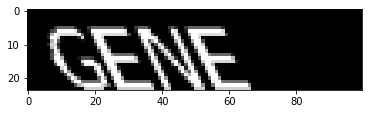

In [22]:
# 绘制图像
image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap='gray')

- 将图像切分为单个的字母

In [25]:
def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        # 通过region对象就能获取到当前区域的相关信息
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image, ]
    return subimages

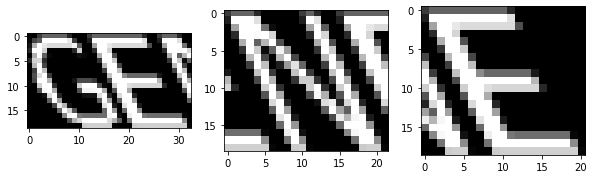

In [31]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 4))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap='gray')

- 创建训练集

The target for this image is: 20


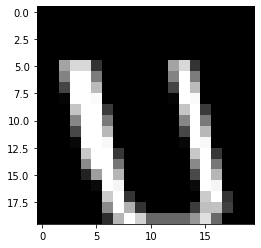

In [36]:
random_state = check_random_state(2021)
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear, size=(20, 20)), letters.index(letter)
image, target = generate_sample(random_state)
plt.imshow(image, cmap='gray')
print("The target for this image is: {0}".format(target)) 

In [38]:
datasets, targets = zip(*(generate_sample(random_state) for _ in range(3000)))
datasets = np.array(datasets, dtype='float')
targets = np.array(targets)

In [40]:
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0], 1))
y = y.todense()

In [41]:
from skimage.transform import resize
datasets = np.array([resize(segment_image(sample)[0], (20, 20)) for sample in datasets])
X = datasets.reshape(datasets.shape[0], datasets.shape[1] * datasets.shape[2])

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2021)

In [44]:
# 训练和分类
# pip install https://github.com/pybrain/pybrain/archive/0.3.3.zip

In [48]:
from pybrain.datasets import SupervisedDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [51]:
train_data = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    train_data.addSample(X_train[i], y_train[i])

test_data = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    test_data.addSample(X_test[i], y_test[i])

In [52]:
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

trainer = BackpropTrainer(net, train_data, learningrate=0.01, weightdecay=0.01)
trainer.trainEpochs(epochs=20)

predictions = trainer.testOnClassData(dataset=test_data)

print("F-score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1),average='micro')))
print(classification_report(y_test.argmax(axis=1), predictions))

F-score: 0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         9
           2       0.80      1.00      0.89        12
           3       1.00      1.00      1.00        13
           4       1.00      0.64      0.78        11
           5       0.75      1.00      0.86        12
           6       1.00      0.73      0.84        11
           7       1.00      1.00      1.00        13
           8       0.71      1.00      0.83        17
           9       1.00      0.73      0.85        15
          10       1.00      1.00      1.00         8
          11       0.77      0.71      0.74        14
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00         9
          17 

In [53]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [ ]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
